Routes:  LLM will make decision and select one path

LLM based upon input will decide to navigate to [joke,story,poem]

In [25]:
## create a llm model
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10b1960c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10b197110>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
from typing_extensions import Literal, TypedDict
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel, Field

#schema for structured output
class route(BaseModel):
      step: Literal["poem","story","joke"] = Field(
            None,description="The next step in the routing process")
      
router = llm.with_structured_output(route)

#State
class State(TypedDict):
      input: str
      output: str
      decison: str

def joke(state: State):
    msg = llm.invoke(f"Write a joke about {state['input']}",)
    return {"output": msg.content}
def story(state: State):
    msg = llm.invoke(f"Write a story about {state['input']}",)
    return {"output": msg.content}
def poem(state: State):
    msg = llm.invoke(f"Write a poem about {state['input']}",)
    return {"output": msg.content}


In [27]:
#conditional routing is done here 
from langchain.schema import SystemMessage, HumanMessage

def llm_call_router(state: State):
    """Route the input to the appropriate function"""
    decision = router.invoke([
        SystemMessage(
            content="You are a routing agent. You will route the input to the appropriate function based on the decision made."
        ),
        HumanMessage(
            content=f"Input: {state['input']}"
        ),
    ])
    return {"decision": decision.step}

In [28]:
# condition edge functions to route to the appropriate function
def route_decision(state:State):
      #return the node you want to visit
      if state["decision"] == "poem":
            return poem(state)
      elif state["decision"] == "story":
            return story(state)
      elif state["decision"] == "joke":
            return joke(state)
      else:
            raise ValueError(f"Invalid decision: {state['decision']}")

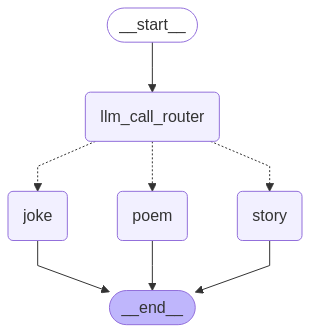

In [29]:
#Build workflow

router_builder = StateGraph(State)

#add nodes

router_builder.add_node("joke",joke)
router_builder.add_node("story",story)
router_builder.add_node("poem",poem)
router_builder.add_node("llm_call_router",llm_call_router)
router_builder.add_conditional_edges("llm_call_router",route_decision,{
      "poem": "poem",
      "story": "story",
      "joke": "joke"
})
#add edges
router_builder.add_edge(START,"llm_call_router")
router_builder.add_edge("joke",END)
router_builder.add_edge("story",END)
router_builder.add_edge("poem",END)
#build the workflow
router_builder.compile()
#run the workflow

In [30]:
router_workflow= router_builder.compile()

state = router_workflow.invoke({"input":"Dogs"})
print(state["output"])


KeyError: 'decision'